<a href="https://colab.research.google.com/github/emincingoz/Machine_Learning_Collection/blob/tensorflow_keras/Transfer_Learning_with_VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive


In [3]:
import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow.keras.utils import to_categorical

In [4]:
# Load images and labels

(train_set, train_labels), (test_set, test_labels)= tfds.load(name = 'tf_flowers', 
                                                                   split = ['train[:70%]', 'train[:30%]'],   # train test splitting 
                                                                   as_supervised = True,                    # include labels
                                                                   batch_size = -1, 
                                                                   #with_info = True
                                                                   )

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.



Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]


Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.
Instructions for updating:
Use `tf.data.Dataset.get_single_element()`.


Instructions for updating:
Use `tf.data.Dataset.get_single_element()`.


In [5]:
print(train_set.shape)
print(train_labels.shape)
print(test_set.shape)
print(test_labels.shape)

(2569, 442, 1024, 3)
(2569,)
(1101, 442, 1024, 3)
(1101,)


In [24]:
ds, dataset_info = tfds.load(name = 'tf_flowers', with_info = True, as_supervised = True, split = ['train[:70%]', 'train[:30%]'])

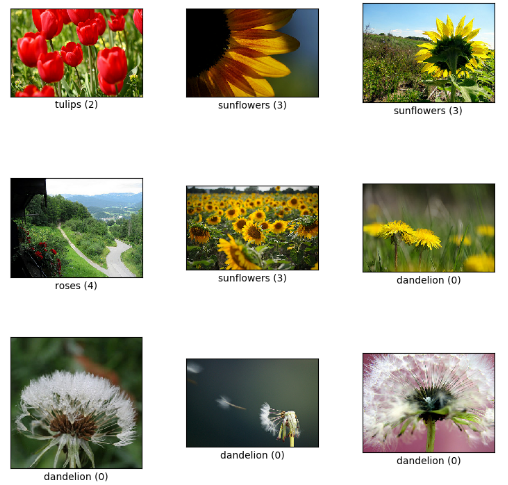

In [25]:
import numpy as np

class_names = np.array(dataset_info.features['label'].names)
print(class_names)

['dandelion' 'daisy' 'tulips' 'sunflowers' 'roses']


In [27]:
# Resizing images
train_set = tf.image.resize(train_set, (180, 180))
test_set = tf.image.resize(test_set, (180, 180))

# Transform labels to one encoded form
train_labels = to_categorical(train_labels, num_classes = 5)
test_labels = to_categorical(test_labels, num_classes = 5)

In [28]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

# Loading VGG16 model
# include_top = False, to remove classification layer
base_model = VGG16(weights = 'imagenet', include_top = False, input_shape = train_set[0].shape)

# Not trainable weights
base_model.trainable = False

58900480/58889256 [==============================] - 1s 0us/step


In [29]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

In [34]:
from tensorflow.keras import layers, models

# Build Classification layers.
flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(units = 70, activation = 'relu')
dense_layer_2 = layers.Dense(units = 50, activation = 'relu')
dense_layer_3 = layers.Dense(units = 30, activation = 'relu')
output_layer = layers.Dense(units = 5, activation = 'softmax')

model = models.Sequential([
                           base_model, 
                           flatten_layer, 
                           dense_layer_1, 
                           dense_layer_2, 
                           dense_layer_3, 
                           output_layer
                          ])

In [35]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 5, 5, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 12800)             0         
                                                                 
 dense_3 (Dense)             (None, 70)                896070    
                                                                 
 dense_4 (Dense)             (None, 50)                3550      
                                                                 
 dense_5 (Dense)             (None, 30)                1530      
                                                                 
 dense_6 (Dense)             (None, 5)                 155       
                                                                 
Total params: 15,615,993
Trainable params: 901,305
Non

In [36]:
from tensorflow.keras.callbacks import EarlyStopping

model.compile(optimizer = 'adam', 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

earlyStop = EarlyStopping(monitor = 'val_accuracy', 
                          mode = 'max', 
                          patience = 5, 
                          restore_best_weights = True)

model.fit(train_set, 
          train_labels, 
          epochs = 50, 
          validation_split = 0.2, 
          batch_size = 32, 
          callbacks = [earlyStop])

Epoch 1/50
65/65 [==============================] - 17s 255ms/step - loss: 1.9473 - accuracy: 0.4730 - val_loss: 1.5032 - val_accuracy: 0.5156
Epoch 2/50
65/65 [==============================] - 16s 249ms/step - loss: 0.8354 - accuracy: 0.6973 - val_loss: 1.1482 - val_accuracy: 0.6304
Epoch 3/50
65/65 [==============================] - 16s 251ms/step - loss: 0.5473 - accuracy: 0.8044 - val_loss: 1.1190 - val_accuracy: 0.6498
Epoch 4/50
65/65 [==============================] - 16s 253ms/step - loss: 0.3381 - accuracy: 0.8895 - val_loss: 1.1908 - val_accuracy: 0.6595
Epoch 5/50
65/65 [==============================] - 16s 254ms/step - loss: 0.1919 - accuracy: 0.9353 - val_loss: 1.2326 - val_accuracy: 0.6809
Epoch 6/50
65/65 [==============================] - 16s 252ms/step - loss: 0.1361 - accuracy: 0.9630 - val_loss: 1.3748 - val_accuracy: 0.6673
Epoch 7/50
65/65 [==============================] - 16s 252ms/step - loss: 0.1222 - accuracy: 0.9611 - val_loss: 1.3823 - val_accuracy: 0.6654

In [37]:
score = model.evaluate(test_set, test_labels)

35/35 [==============================] - 9s 249ms/step - loss: 0.1255 - accuracy: 0.9700


In [41]:
print('Test Set Loss: ', score[0])
print('Test Set Accuracy: ', score[1])

Test Set Loss:  0.12545302510261536
Test Set Accuracy:  0.9700272679328918


In [78]:
prediction = model.predict(test_set)
prediction

array([[3.1245797e-08, 6.5587784e-08, 9.9998724e-01, 1.0616582e-08,
        1.2592597e-05],
       [6.8193771e-02, 3.7578200e-03, 2.1799041e-03, 8.8613081e-01,
        3.9737690e-02],
       [1.3088752e-01, 1.1379766e-02, 5.1476564e-03, 8.5243809e-01,
        1.4696915e-04],
       ...,
       [1.3767229e-04, 1.8044877e-04, 9.9897265e-01, 1.4660724e-05,
        6.9460319e-04],
       [1.2333256e-02, 1.7087508e-04, 1.2982673e-03, 9.3719773e-03,
        9.7682559e-01],
       [6.2878707e-06, 3.9530443e-03, 9.9603736e-01, 2.1312437e-06,
        1.1966030e-06]], dtype=float32)

In [81]:
prediction[0]

array([3.1245797e-08, 6.5587784e-08, 9.9998724e-01, 1.0616582e-08,
       1.2592597e-05], dtype=float32)

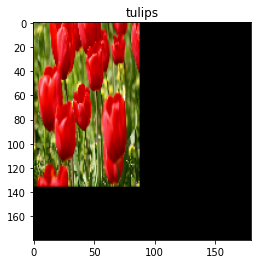

In [80]:
plt.imshow(test_set[0].reshape(180, 180, 3).astype('uint8'))
plt.title(class_names[prediction[0].argmax()])
plt.show()

In [82]:
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

prediction = model.predict(test_set[15].reshape(1, 180, 180, 3)).argmax()

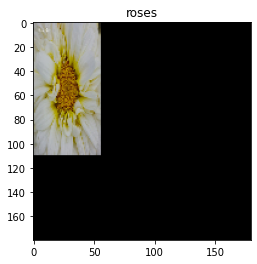

In [83]:
plt.imshow(test_set[15].reshape(180, 180, 3).astype('uint8'))
plt.title(class_names[prediction])
plt.show()